# Capítulo 3. CLASIFICACION

En el capítulo 1 mencionamos que las tareas más comunes del aprendizaje supervisado eran la regresión (predicción de valores) y la clasificación (predicción de clases). En el capítulo 2 exploramos la tarea de regresión, predicción de precios de las viviendas, usando varios algoritmos, como la regresión lineal, árboles de decisión y bosques aletarios. Ahora centraremos nuestra atención en los sistemas de clasificación.

# MNIST

En este capítulo usaremos el dataset de MNIST, que es un conjunto de 70.000 pequeñas imágenes de dígitos escritos a mano por estudiantes y empleados de la Oficina Censal de EEUU. Cada imagen está etiquetada con el dígito que representa. Este conjunto ha sido tanto que a menudo se le denomina el "Hello World" del Machine Learning: cualquier persona que se inicie con un nuevo algoritmo de clasificación tendrá curiosidad de ver cómo se ejecutará en MNIST. Cada vez que alguien aprende Machine Learning, tarde o temprano se enfrentará a MNIST.

Scikit-Learn proporciona muchas funciones de ayuda para descargar datasets populares. MNIST es uno de ellos. El siguiente código obtiene el dataset MNIST (Por defecto, Scikit-LEarn cachea los datasets descargados en un directorio llamado: *\\$HOME/scikit_learn_data*):

In [1]:
# imports comunes
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Hacer las salidas de este notebook estables a través de ejecuciones
np.random.seed(42)

# Hacemos algunos ajustes a los gráficos
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784", version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

Generalmente, los dataset cargados por Scikit-Learn tienen una estructura similar a undiccionario, incluyendo:

+ una clave `DESCR` describiendo el dataset
+ una clave `data` conteniendo un array con una fila por cada instancia y una columna por cada característica
+ una clave `target` conteniendo un array con las etiquetas (objetivo)

Echemos un vistazo a estos arrays:

In [3]:
X, y = mnist["data"], mnist["target"]
print(f"X: {X.shape}\ny: {y.shape}")

X: (70000, 784)
y: (70000,)


Hay 70.000 imágenes y cada imagen tiene 784 características. Esto es así porque cada imagen son 28x28 pixels, donde cada característica representa un pixel de intensidad, de 0 (blanco) a 255 (negro). Echemos un vistazo a un dígito del dataset. Todo lo que necesitamos es tomar el vector de características de una instancia, redimensionarlo a una matriz de 28 × 28 y mostrarlo usando la función `imshow()` de Matplotlib:

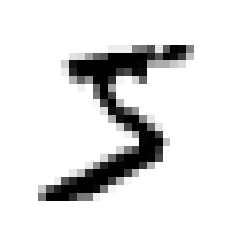

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap=mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

Parece que es un 5, y de hecho es lo que nos dice su etiqueta:

In [5]:
y[0]

'5'

Fijémonos que la etiqueta es una cadena. Preferimos números, así que vamos a convertir `y` a enteros:

In [6]:
y = y.astype(np.uint8)

In [7]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [8]:

# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Veamos algunas imágenes más del dataset de MNIST para que tener una impresión de la complejidad de la tarea de clasificación.

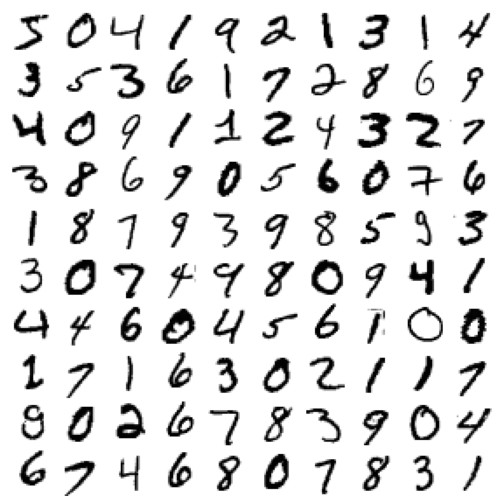

In [9]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
plt.show()

¡Espera! Siempre debemos crear un conjunto de pruebas y apartarlo antes de inspeccionar los datos de cerca. El conjunto de datos MNIST ya está dividido en un conjunto de entrenamiento (las primeras 60.000 imágenes) y un conjunto de prueba (las últimas 10.000 imágenes):

In [10]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

El conjunto de entrenamiento ya está mezclado para nosotros, lo cual es bueno ya que esto garantiza que todas las particiones de validación cruzada serán similares (no queremos ninguna partición omita algún dígito). Además, algunos algoritmos de aprendizaje son sensibles al orden de las instancias de entrenamiento y tienen un bajo rendimiento si obtienen muchas instancias similares seguidas. Al barajar el conjunto de datos se garantiza que esto no suceda (mezclar los datos puede ser una mala idea en algunos contextos, por ejemplo si estamos trabajando con datos de series temporales, como los precios de mercado de stock o las condiciones meteorológicas).

# Entrenar un clasificador binario

Vamos a simplificar el problema y vamos a tratar de identificar un dígito (por ejemplo, el número 5). Este "detector de 5" será un ejemplo de un *clasificador binario*, capaz de distinguir solo entre dos clases, 5 y no-5 . Creemos los vectores objetivo de esta tarea de clasificación:

In [11]:
y_train_5 = (y_train == 5)  # True para todos los 5s, False para el resto de dígitos
y_test_5 = (y_test == 5)

Bien, ahora vamos a elegir un clasificador y entrenarlo. Un buen lugar para comenzar es con un clasificador *Stochastic Gradient Descent* (SGD), utilizando la clase `SGDClassifier` de Scikit-Learn. Este clasificador tiene la ventaja de ser capaz de manejar conjuntos de datos muy grandes de manera eficiente. Esto se debe en parte a que SGD se ocupa de las instancias de entrenamiento de forma independiente, una a la vez (lo que también hace que SGD sea adecuado para el *aprendizaje online*), como veremos más adelante. Vamos a crear un `SGDClassifier` y entrenarlo en el conjunto de entrenamiento completo:

In [12]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

---
`SGDClassifier` se basa en la aleatoriedad durante el entrenamienti (de ahí el nombre de "estocástico"). Si queremos resultados reproducibles debemos establecer el parámetro `random_state`.

---

Ahora podemos usarlo para detectar imágenes del número 5:

In [13]:
sgd_clf.predict([some_digit])

array([ True])

El clasificador supone que esta imagen representa un 5 (`True`). Parece que acertó en este caso en particular. Ahora vamos a evaluar la ejecución del modelo.

# Medidas del rendimiento

Evaluar un clasificador es a menudo significativamente más complicado que evaluar un regresor, por lo que dedicaremos gran parte de este capítulo a este asunto. Existen muchas medidas disponibles del rendimiento, así que cojamos otro café y preparémonos para aprender muchos conceptos y acrónimos.

## Medida de la precisión usando Validación Cruzada

Una buena forma de evaluar un modelo es usar validación cruzada, como vimos en el capítulo 2.

---
**Implementación de la validación cruzada**

Ocasionalmente necesitaremos más control sobre el proceso de validación cruzada del que Scikit-Learn nos proporciona. En eso casos, podemos implementar la validación cruzada por nosotros mismos; en realidad es bastante sencillo. El siguiente código hace más o menos los mismo que la función `cross_val_score()` de Scikit-Learn y muestra el mismo resultado:


In [14]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred)) # muestra 0.9502, 0.96565 and 0.96495

C:\Program Files\Python38\lib\site-packages\sklearn\model_selection\_split.py:292: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


0.95035
0.96035
0.9604


La clase `StratifiedFold` ejecuta un muestreo estratificado para generar particiones que contengan un ratio representantivo de cada clase. En cada iteración el código crea un clon del clasificador, entrena ese clon en las particiones de entrenamiento y realiza las predicciones en la partición de prueba. Después cuenta el número de predicciones correctas y devuelve el ratio de predicciones correctas.

---

Vamos a usar  la función `cross_val_score()` para evaluar nuestro model `SGDClassifier` usando validación cruzada, con 3 particiones. Recordemos que la validación cruzada significa dividir el conjunto de entrenamiento en K-particiones (en este caso, tres), después realizamos las predicciones y evaluamos en cada partición usando un modelo entrenado en las particiones restantes.

In [15]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy", n_jobs=-1)

array([0.95035, 0.96035, 0.9604 ])

¿Más del 95% de precisión (relación de predicciones correctas) en todos los folds de validación cruzada? Esto es increíble, ¿no? Bueno, antes de que nos emocionemos demasiado pensemos en un clasificador muy tonto que simplemente clasifica cada imagen en la clase "no 5":

In [16]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [17]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy", n_jobs=-1)

array([0.91125, 0.90855, 0.90915])

¡Así es, tiene más del 90% de precisión! Esto se debe simplemente a que solo el 10% de las imágenes son 5, por lo que si siempre adivina que una imagen no es un 5, tendrá razón aproximadamente el 90% del tiempo. Vence a Nostradamus.

Esto demuestra por qué la precisión generalmente no es la medida de rendimiento preferida para los clasificadores, especialmente cuando se trata de *conjuntos de datos sesgados* (es decir, cuando algunas clases son mucho más frecuentes que otras).

## Matriz de Confusión

Una forma mucho mejor de evaluar la ejecución de un clasificador es la *matriz de confusión*. La idea general es contar el número de veces que las instancias de la clase A son clasificadas como clase B. Por ejemplo, para saber el número de veces que el clasificador confunde imágenes de 5s con 3s, miraría en la fila 5ª y columna 3ª de la matriz de confusión.

Para calcular la matriz de confusión, primero necesitamos disponer de un conjunto de predicciones, así podemos compararlas con los objetivos reales. Podríamos realizar las predicciones en el conjunto de prueba pero mantengámoslos sin tocar por ahora (recuerda que solo queremos usar el conjunto de prueba muy al final del proyecto, una vez que tenemos un clasificador listo para poner en producción). En su lugar, utilizaremos la función `cross_val_predict()`.

In [18]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, n_jobs=-1)

Al igual que la función `cross_val_score`, `cross_val_prediction` ejecuta validación cruzada, pero en lugar de devolver las puntuaciones de la evaluación, devuelve las predicciones realizadas en cada partición de prueba. Esto significa que obtenemos una predicción limpia por cada instancia en el conjunto de entrenamiento ("limpia" significa que la predicción se ha realizado por un modelo que nunca ha visto los datos durante el entrenamiento).

Ahora ya estamos preparados para obtener la matriz de confusión usando `confusion_matrix()`. Solo hay que pasar las clases objetivo (`y_train_5`) y las clases predichas (`y_train_pred`):

In [19]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

Cada fila en una matriz de confusión representa una *clase real*, mientras que cada columna representa una *clase predicha*. La primera fila de esta matriz considera imágenes no-5 (la *clase negativa*): 53.892 de ellas se clasificaron correctamente como no-5 (se llaman *verdaderos negativos*), mientras que las 687 restantes se clasificaron erróneamente como 5s (*falsos positivos*). La segunda fila considera las imágenes de 5s (la *clase positiva*): 1.891 se clasificaron erróneamente como no-5s (*falsos negativos*), mientras que los 3.530 restantes se clasificaron correctamente como 5s (*verdaderos positivos*). Un clasificador perfecto solo tendría verdaderos positivos y verdaderos negativos, por lo que su matriz de confusión tendría valores distintos de cero solo en su diagonal principal (desde arriba a la izquierda a la parte inferior derecha):

In [20]:
y_train_perfect_predictions = y_train_5  # pretendemos alcanzar la perfección
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

La matriz de confusión proporciona mucha información, pero a veces podemos preferir una métrica más concisa. Una interesante es la precisión de las predicciones positivas: esto se llama la *precisión* del clasificador.

$precision = \frac{VP}{VP + FP}$

Es decir, precisión = verdaderos positivos / (verdaderos positivos + falsos  positivos)

Una forma trivial de tener una precisión perfecta es hacer una sola predicción positiva y asegurarse de que sea correcta (precisión = 1/1 = 100%). Esto no sería muy útil ya que el clasificador ignoraría todas las instancias, excepto una positiva. Por lo tanto, la precisión se usa normalmente junto con otra métrica llamada *recall*, también llamada *sensibilidad* o *ratio de verdaderos positivos* (TPR): esta es la proporción de instancias positivas que el clasificador detecta correctamente.

$sensibilidad = \frac{VP}{VP + FN}$

Es decir, sensibilidad o recall = verdaderos positivos / (verdaderos positivos + falsos negativos)

![confusion_matrix](images/ch03/confusion_matrix.png)

## Precisión y Sensibilidad

Scikit-Learn proporciona varias funciones para calcular métricas de clasificadores, incluyen la precisión y la sensibilidad:

In [21]:
from sklearn.metrics import precision_score, recall_score

print(f"Precisión:    {precision_score(y_train_5, y_train_pred)}") # == 3530 / (3530 + 687)
print(f"Sensibilidad: {recall_score(y_train_5, y_train_pred)}")    # == 3530 / (3530 + 1891)

Precisión:    0.8370879772350012
Sensibilidad: 0.6511713705958311


Parece que ahora nuestro detector de 5s no se ve tan brillante como lo hizo cuando calculamos su precisión. Cuando dice que una imagen representa un 5, es correcto solo el 83,7% de las veces. Además, solo detecta el 65,1% de los 5s.

A menudo es conveniente combinar precisión y sensibilidad en una sola métrica llamada *puntuación* $F_1$ (*F1 score*), en particular si necesitamos una forma sencilla de comparar dos clasificadores. La puntuación $F_1$ es la *media armónica* de precisión y sensibilidad (ecuación 3-3). Mientras que la media regular trata a todos los valores por igual, la media armónica otorga mucho más peso a los valores bajos. Como resultado, el clasificador solo obtendrá una puntuación alta en $F_1$ si tanto la sensibilidad como la precisión son altas.

$F_1 = \frac{2}{\frac{1}{precision} + \frac{1}{sensibilidad}} = 2 \times \frac{precision\, \times\, sensibilidad}{precision\, +\, sensibilidad} = \frac{VP}{VP\,+\,\frac{FN\,+\,FP}{2}}$

Para calcular la puntuación $F_1$ simplemente llamamos a la función `f1_score()`:

In [22]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

La puntuación de $F_1$ favorece a los clasificadores que tienen una precisión y sensibilidad similares. Esto no es siempre lo que queremos: en algunos contextos, nos importará la precisión y en otros contextos realmente nos importa la sensibilidad. Por ejemplo, si entrenamos a un clasificador para que detecte videos que sean seguros para los niños, probablemente preferiremos un clasificador que rechace muchos videos buenos (sensibilidad baja) pero que mantenga solo los seguros (alta precisión), en lugar de un clasificador que tenga mucho mayor sensibilidad, pero que permita que algunos videos realmente malos se muestren en nuestro producto (en tales casos, es posible que deseemos agregar un control humano para verificar la selección de videos del clasificador). Por otro lado, supongamos que entrenamos a un clasificador para detectar ladrones en las imágenes de vigilancia: probablemente esté bien si su clasificador tiene solo un 30% de precisión, siempre que tenga un 99% de sensibilidad (seguro, los guardias de seguridad recibirán algunas alertas falsas, pero casi todos los ladrones serán atrapados).

Desafortunadamente, no podemos tenerlo de las dos maneras: aumentar la precisión reduce la sensibilidad, y viceversa. Esto se llama *compensación de precisión/sensibilidad*.

## Compensación precisión/Sensibilidad

Para entender este equilibrio, veamos cómo `SGDCClassifier` toma sus decisiones de clasificación. Para cada instancia, calcula una puntuación basada en una *función de decisión* y si esa puntuación es mayor que un umbral, asigna la instancia a la clase positiva, o bien la asigna a la clase negativa. En la siguiente figura se muestran algunos dígitos ubicados desde la puntuación más baja de la izquierda hasta la puntuación más alta de la derecha. Supongamos que el *umbral de decisión* se ubica en la flecha central (entre los dos 5): encontrará 4 verdaderos positivos (5s reales) a la derecha de ese umbral, y un falso positivo (en realidad un 6). Por lo tanto, con ese umbral la precisión es del 80% (4 de 5). Pero de 6 reales 5s, el clasificador solo detecta 4, por lo que la sensibilidad es del 67% (4 de 6). Ahora, si aumentamos el umbral (movemos la flecha a la derecha), el falso positivo (el 6) se convierte en un verdadero negativo, lo que aumenta la precisión (hasta el 100% en este caso), pero un verdadero positivo se convierte en un falso negativo, disminuyendo la sensibilidad hasta el 50%. Por el contrario, bajar el umbral aumenta la sensibilidad y reduce la precisión.

![decision_threshold](images/ch03/decision_threshold.png)

Scikit-Learn no nos permite establecer el umbral directamente, pero nos da acceso a las puntuaciones de decisión que utiliza para hacer predicciones. En lugar de llamar al método `predict()` del clasificador, llamamos a su método `decision_function()`, que devuelve una puntuación para cada instancia y luego hace predicciones basadas en esas puntuaciones utilizando cualquier umbral que deseemos:

In [23]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [24]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

`SGDClassifier` usa un umbral igual a 0, como vemos. Por tanto, devuelve el mismo resultado que el método `predict()` (es decir, `True`). Vamos a subir el umbral:

In [25]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

Esto confirma que elevar el umbral disminuye la sensibilidad. La imagen en realidad representa un 5 y el clasificador lo detecta cuando el umbral es 0, pero lo pierde cuando el umbral se incrementa a 8.000. 

Entonces, ¿cómo podemos decidir qué umbral usar? Para ello, primero deberemos obtener las puntuaciones de todas las instancias en el conjunto de entrenamiento utilizando la función `cross_val_predict()` nuevamente, pero esta vez especificando que queremos que devuelva las puntuaciones de decisión en lugar de las predicciones:

In [26]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                            method="decision_function", n_jobs=-1)

Ahora, con estas puntuaciones podemos calcular la precisión y la sensibilidad para todos los umbrales posibles utilizando la función `precision_recall_curve()`:

In [27]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Por último, podemos dibujar la precisión y la sensibilidad como funciones del umbral:

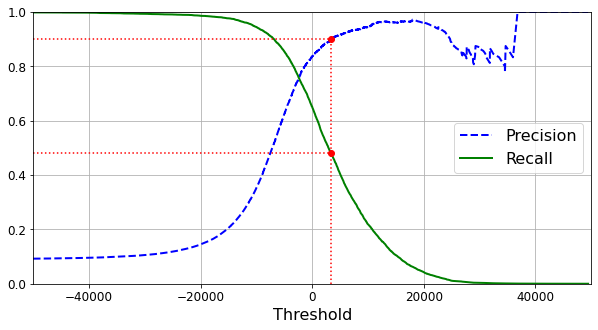

In [28]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown

recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.figure(figsize=(10, 5))                                                                 
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                             
plt.plot([threshold_90_precision], [recall_90_precision], "ro");

---
Quizás nos preguntemos por qué la curva de precisión es más irregular que la de sensibilidad. La razón es que la precisión algunas veces puede caer cuando sube el umbral (aunque en general subirá). Para comprender por qué, volvamos a mirar la figura donde hablábamos de la compensación entre precisión y sensibilidad y observemos qué pasa cuando comenzamos desde el umbral central y lo movemos solo un dígito a la derecha: la precisión disminuye de 4/5 (80%)  a 3/4 (75%). Por otro lado, la sensibilidad solo disminuye cuando se incrementa el umbral, lo que explica por qué la curva se ve suave.

---

Otra forma de seleccionar un buen equlibrio precisión/sensibilidad es trazar la precisión directamente contra la sensibilidad:

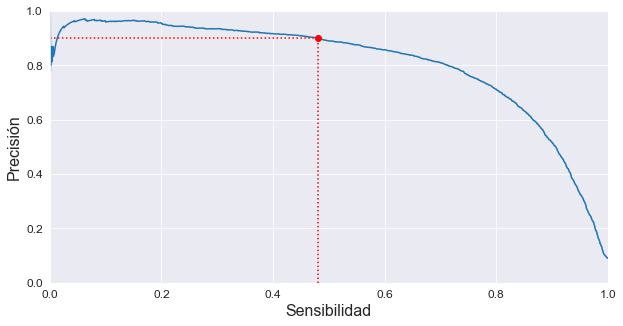

In [45]:
def plot_precision_vs_recall(precisions, recalls):
    ax = sns.lineplot(x=recalls, y=precisions)
    plt.xlabel("Sensibilidad", fontsize=16)
    plt.ylabel("Precisión", fontsize=16)
    plt.axis([0, 1, 0, 1])
    
sns.set_style("darkgrid")
figure, axs = plt.subplots(figsize=(10,5))
plot_precision_vs_recall(precisions, recalls)
plt.plot([0.4799, 0.4799], [0., 0.9], "r:")
plt.plot([0.0, 0.4799], [0.9, 0.9], "r:")
plt.plot([0.4799], [0.9], "ro");

Se puede ver que la precisión realmente comienza a caer bruscamente en torno al 80% de sensibilidad. Es probable que queramos seleccionar una compensación de precisión/sensibilidad justo antes de esa caída, por ejemplo, en aproximadamente el 60% de sensibilidad. Pero, por supuesto, la elección depende de nuestro proyecto. 

Así que supongamos que decidimos apuntar a una precisión del 90%. Buscamos en el primer gráfico (acercando un poco el zoom) y descubrimos que necesitamos usar un umbral de aproximadamente 3.300. Para ser más precisos podemos buscar el menor umbral que nos da al menos el 90% de precisión (`np.argmax()` no devolverá el primer índice el valor máximo, que en este caso significa el primer valor `True`):

In [40]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

Para hacer predicciones (en el conjunto de entrenamiento por ahora), en lugar de llamar al método `predict()` del clasificador, podemos ejecutar este código:

In [41]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

Verifiquemos la precisión y la sensibilidad de las predicciones:

In [42]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [43]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

¡Genial, ya tenemos un clasificador con una precisión del 90%! Como podemos ver es bastanta fácil crear un clasificador con virtualmente cualquier precisión que queramos: solo hay que establecer un umbral suficientemente alto y ya está. Hmmm, no tan rápido. Un clasificador de alta precisión no es muy útil si la sensibilidad es demasiado baja.

---
Si alguien dice "alcancemos el 99% de precisión", debemos preguntarle "¿Con qué sensibilidad?"

---

## La curva ROC

La curva ROC (*receiver operating characteristic*) es otra herramienta común que se utiliza con los clasificadores binarios. Es muy similar a la curva de precisión/sensibilidad, pero en lugar de trazar la precisión frente a la sensibilidad, la curva ROC traza el *ratio de verdaderos positivos* (otro nombre para la sensibilidad) contra la *tasa de falsos positivos* (FPR). El FPR es el ratio de casos negativos que se clasifican incorrectamente como positivos. Es igual a uno menos la *tasa de verdaderos negativos* (TNR), que es el ratio de casos negativos que se clasifican correctamente como negativos. El TNR también se llama *especificidad*. Por lo tanto, la curva ROC representa la *sensibilidad* (recall) versus 1 - *especificidad*.

Para dibujar la curva ROC, lo primero que necesitamos es calcular el TPR y FPR para varios valores de umbral, usando la función `roc_curve()`:

In [46]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

Entonces podemos dibujar el FPR contra el TPR:

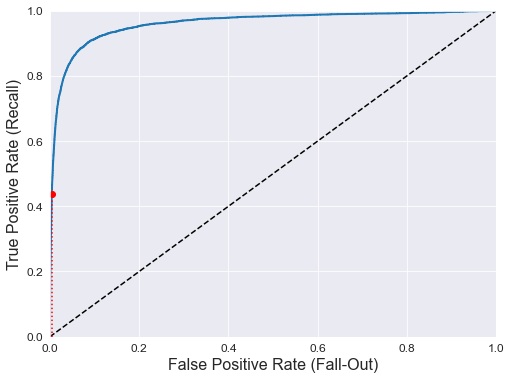

In [48]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                            

plt.figure(figsize=(8, 6))                         
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") 
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  
plt.plot([4.837e-3], [0.4368], "ro");

Una vez más, hay una compensación: cuanto mayor sea la sensibilidad (TPR), más falsos positivos (FPR) el clasificador produce. La línea de puntos representa la curva ROC de un clasificador puramente aleatorio. Un buen clasificador se mantiene lo más alejado posible de esa línea (hacia la esquina superior izquierda).

Una forma de comparar los clasificadores es medir el *área bajo la curva* (AUC). Un clasificador perfecto tendrá una ROC AUC igual a 1, mientras que un clasificador puramente aleatorio tendrá una AUC ROC igual a 0.5.

In [49]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

---
Dado que la curva ROC es muy similar a la curva precisión/sensibilidad (o PR), es posible que nos preguntemos cuál de ellas debemos elegir. Como regla general, deberíamos preferir la curva PR siempre que la clase positiva sea rara o cuando nos preocupen más los falsos positivos que los falsos negativos, y la curva ROC al contrario. Por ejemplo, al observar la curva ROC anterior (y la puntuación ROC AUC), podemos pensar que el clasificador en realmente bueno. Pero esto se debe principalmente a que existen pocos positivos (5s) comparados con los negativos (no-5s). En contraste, la curva PR deja claro que el clasificador tiene margen de mejora (la curva podría estar más cerca de la esquina superior derecha).

---

Vamos a entrenar un `RandomForestClassifier` y comparemos su curva ROC y la puntuación ROC AUC con el `SGDClassifier`. Primero, necesitamos obtener puntuaciones para cada instancia en el conjunto de entrenamiento. Pero debido a la forma en que funciona, la clase `RandomForestClassifier` no tiene un método de `decision_function()`. En su lugar, tiene un método `predict_proba()`. Los clasificadores de Scikit-Learn generalmente tienen uno u otro. El método `predict_proba()` devuelve una matriz que contiene una fila por instancia y una columna por clase, cada una conteniendo la probabilidad de que la instancia dada pertenezca a la clase dada (por ejemplo, 70% de probabilidad de que la imagen represente un 5):

In [50]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                   method="predict_proba", n_jobs=-1)

Pero para trazar una curva ROC necesitamos puntuaciones, no probabilidades. Una solución simple es usar la probabilidad de la clase positiva como puntuación:

In [51]:
y_scores_forest = y_probas_forest[:, 1]   # score = proba de clase positiva
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

Ahora ya estamos listos para dibujar la curva ROC. Es útil dibujar primero la curva ROC para ver cómo se comparan:

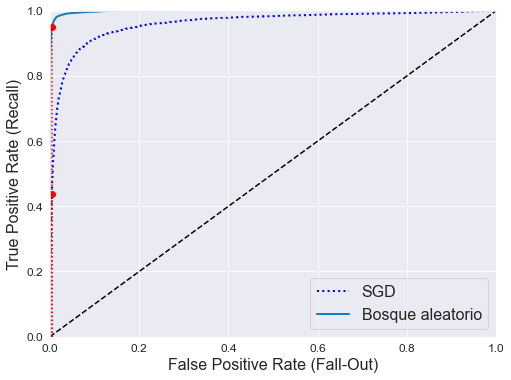

In [54]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Bosque aleatorio")
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:")
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")
plt.plot([4.837e-3], [0.4368], "ro")
plt.plot([4.837e-3, 4.837e-3], [0., 0.9487], "r:")
plt.plot([4.837e-3], [0.9487], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)

Como podemos ver la curva ROC de `RandomForestClassifier` es mucho mejor que la de `SGDClassifier`: está mucho más cerca de la esquina superior izquierda. En consecuencia, la puntuación ROC AUC es significativamente mejor:

In [55]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

Intente medir las puntuaciones de precisión y sensibilidad: debe encontrar una precisión del 99% y una sensibilidad del 86.6%. ¡No está mal!

In [58]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, n_jobs=-1)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [59]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

Ahora sabemos cómo entrenar clasificadores binarios, eligir la métrica adecuada para neustra tarea, evaluar nuestros clasificadores utilizando validación cruzada, seleccionar la compensación de precisión/sensibilidad que se adapte a nuestras necesidades y comparar varios modelos utilizando curvas ROC y puntuaciones AUC ROC. Ahora tratemos de detectar algo más que sólo 5s.

# Clasificación Multiclase

Mientras que los clasificadores binarios distinguen entre dos clases, los *clasificadores multiclase* (también denominados *clasificadores multinomiales*) pueden distinguir entre más de dos clases. Algunos algoritmos (como Random Forest o Naive Bayes) son capaces de manejar multiples clases directamente. Otros (como Support Vector Machine o clasificadores lineales) son clasificadores estríctamente binarios. Sin embargo, existen varias estrategias que podemos usar para ejecutar clasificación multiclase usando múltiples clasificadores binarios.

Por ejemplo, una forma de crear un sistema que pueda clasificar imágenes de dígitos en 10 clases (del 0 al 9) es entrenar 10 clasificadores binarios, uno por cada dígito (un 0-detector, un 1-detector, un 2-detector, etc.). Luego, cuando queremos clasificar una imagen, obtenemos la puntuación de decisión de cada clasificador para esa imagen y seleccionamos la clase cuyo clasificador obtiene la puntuación más alta. Esto se denomina estrategia de *uno contra todos* (one-versus-all, OvA) (también llamada *uno contra el resto*).

Otra estrategia es entrenar un clasificador binario para cada par de dígitos: uno para distinguir 0s y 1s, otro para distinguir 0s y 2s, otro para 1s y 2s, y así sucesivamente. Esto se denomina estrategia de *uno contra uno* (one-versus-one, OvO). Si hay N clases, necesitamos entrenar N × (N - 1) / 2 clasificadores. Para el problema MNIST, esto significa entrenar a ¡45 clasificadores binarios! Cuando quieras clasificar una imagen, debes ejecutar la imagen en los 45 clasificadores y ver qué clase gana la mayoría de los duelos. La principal ventaja de OvO es que cada clasificador solo necesita ser entrenado en la parte del conjunto de entrenamiento para las dos clases que debe distinguir.

Algunos algoritmos (como los clasificadores Support Vector Machine) escalan mal con el tamaño del conjunto de entrenamiento, por lo que para estos algoritmos se prefiere OvO, ya que es más rápido entrenar a muchos clasificadores en conjuntos de entrenamiento pequeños que entrenar a pocos clasificadores en conjuntos de entrenamiento grandes. Sin embargo, para la mayoría de los algoritmos de clasificación binaria, se prefiere OvA.

Scikit-Learn detecta cuando intentas utilizar un algoritmo de clasificación binaria para una tarea de clasificación multiclase y ejecuta automáticamente OvA (excepto para los clasificadores SVM para los que utiliza OvO). Probemos esto con el `SGDClassifier`:

In [68]:
sgd_clf.fit(X_train[:1000], y_train[:1000])   # y_train no y_train_5
sgd_clf.predict([some_digit])

array([5], dtype=uint8)

¡Eso ha sido fácil! Este código entrena al `SGDClassifier` en el conjunto de entrenamiento utilizando las clases objetivo originales de 0 a 9 (`y_train`), en lugar de las clases objetivo de 5 contra todos (`y_train_5`). Luego hace una predicción (una correcta en este caso). Internamente Scikit-Learn realmente entrenó a 10 clasificadores binarios, obtuvo sus puntuaciones de decisión para la imagen y seleccionó la clase con la puntuación más alta.

Para ver en detalle este caso, podemos llamar al método `decision_function()`. En lugar de devolver solo una puntuación por instancia, ahora devuelve 10 puntuaciones, una por clase:

In [69]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-6049581.97985829, -6138036.45541781, -3886281.38604606,
         -604692.42366776, -6948311.32017537,   914498.2913215 ,
        -6855666.78647961, -3866146.33271573, -4016434.08430155,
        -3209136.89074954]])

La mayor puntuación es la que corresponde a la clase 5:

In [70]:
np.argmax(some_digit_scores)

5

In [71]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [73]:
sgd_clf.classes_[5]

5

---
Cuando se entrena un clasificador, almacena la linesta de clases objetivo en su atributo `classes_`, ordenado por valor. En este caso, el índica de cada clase en el array `classes_` coincide convenientemente con la clase en sí misma (es decir, la clase en el índice 5 es la clase 5), pero en general no seremos tan afortunados.

---

Si queremos forzar a ScikitLearn a usar uno-contra-uno o uno-contra-todos, podemos usar las clases `OneVsOneClassifier` o `OneVsRestClassifier`. Simplemente creamos una instancia y pasamos un clasificador binario a su constructor. Por ejemplo, este código crea un clasificador multiclase usando la estrategia OvO, basado en un clasificador `SGDClassifier`:

In [75]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train[:1000], y_train[:1000])
ovo_clf.predict([some_digit])

array([5], dtype=uint8)

In [76]:
len(ovo_clf.estimators_)

45

Entrenar un `RandomForestClassifier` es tan fácil como esto:

In [80]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5], dtype=uint8)

Esta vez, Scikit-Learn no tuvo que ejecutar OvA u OvO porque los clasificadores de Random Forest pueden clasificar directamente las instancias en varias clases. Podemos llamar a `predict_proba()` para obtener la lista de probabilidades que el clasificador asignó a cada instancia para cada clase:

In [81]:
forest_clf.predict_proba([some_digit])

array([[0.  , 0.  , 0.01, 0.08, 0.  , 0.9 , 0.  , 0.  , 0.  , 0.01]])

Vemos que el clasificador está bastante seguro de su predicción: 0.90 para el 5º índice del array significa que el modelo estima un 90% de probabilidad de que la imagen representa un 5. También piensa que la imagen podría ser un 2 o un 3(a un 1% y 8% de probabilidad, respectivamente).

Ahora evaluemos estos clasificadores. Como de costumbre, utilizaremos la validación cruzada. Evaluemos la precisión del `SGDClassifier` usando la función `cross_val_score()`:

In [82]:
cross_val_score(sgd_clf, X_train, y_train, cv=3,
               scoring="accuracy", n_jobs=-1, verbose=2)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.4min finished


array([0.87365, 0.85835, 0.8689 ])

Consigue más del 85% en todas las particiones de prueba. Si utilizáramos un clasificador aleatorio, obtendríamos un 10% de precisión, por lo que no es una puntuación tan mala, pero podemos hacerlo mucho mejor. Por ejemplo, simplemente escalando las entradas (como se explica en el Capítulo 2) aumentaríamos la precisión por encima del 90%:

In [83]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, 
                scoring="accuracy", n_jobs=-1, verbose=2)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  3.2min finished


array([0.8983, 0.891 , 0.9018])

# Análisis de error